In [1]:
# # Configuration related preprocessing step before mounting the drive
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')



In [3]:
#3 set directory path for dataset
import os
# os.chdir("/content/drive/My Drive/Mask_Object_Detection")
Dataset='Dataset'
Data_dir=os.listdir(Dataset)
print(Data_dir)

['with_mask', 'without_mask']


In [4]:
# Import necessary libraries

import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

img_rows,img_cols=112,112

images=[]
labels=[]

# to access path of files
for category in Data_dir:
  folder_path=os.path.join(Dataset,category)
  # to access images inside the above path
  for img in os.listdir(folder_path):
    img_path=os.path.join(folder_path,img)
    img=cv2.imread(img_path)
    # print(img.shape)

    try:
      # convert the image into greyscale
      grayscale_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

      # rescaling the gray image into size of 112*112 in order to keep all the image size consistent
      resized_img=cv2.resize(grayscale_img,(img_rows,img_cols))
      images.append(resized_img)
      labels.append(category)
    
    # Handle exception in case of any error occurs
    except Exception as e:
      print("Exception : ",e)

# normalizing the image
images=np.array(images)/255.0
#reshaping the image array without changing the dta of image because we want data in specific format
images=np.reshape(images,(images.shape[0],img_rows,img_cols,1))


# perform one hot encoding on labels since labels are in text format

lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)
labels=np.array(labels)

(train_X,text_X,train_y,test_y)=train_test_split(images,labels,test_size=0.25,random_state=0)

/Users/rashikumra/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/rashikumra/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/rashikumra/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/rashikumra/anaconda3/lib/python3.7/site-packages/tensorflow/

## Build Convolution Neural Network (CNN) classification model


In [5]:
## import necessary keras library (keras )
from keras.models import Sequential
from keras.layers import Dense,Flatten,Activation,Dropout
from keras.layers import Conv2D,MaxPooling2D

## Define model parameters
num_classes=2
batch_size=32

## Build CNN model using Sequental api
model=Sequential()

## First layer group containing convolution, Maxpooling and Relu layers
model.add(Conv2D(64,(3,3),input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

## second layer group containing convolution, Maxpooling and Relu layers
model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

## Flatten and dropout layer to stack the output convolutions above as well as cater overfitting
model.add(Flatten())
model.add(Dropout(0.5))

## Softmax classifier for output layer
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

print(model.summary())

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 110, 110, 64)      640       
_________________________________________________________________
activation_1 (Activation)    (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
________________________________________________

## Plot the model

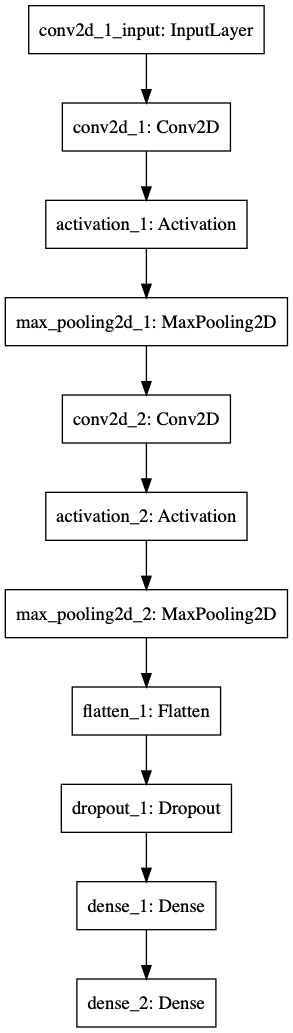

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='FaceMaskDetectionArchitecture.png')

## Train the model

In [7]:
from keras.optimizers import Adam

epochs = 5

model.compile(optimizer=Adam(lr=0.01),loss='categorical_crossentropy',metrics =['accuracy'])

fitted_model=model.fit(train_X,train_y,epochs=epochs,validation_split=0.25)

Instructions for updating:
Use tf.cast instead.
Train on 438 samples, validate on 147 samples
Epoch 1/5
438/438 [==============================] - 54s 124ms/step - loss: 7.5198 - accuracy: 0.5137 - val_loss: 8.7718 - val_accuracy: 0.4558
Epoch 2/5
438/438 [==============================] - 55s 126ms/step - loss: 7.9486 - accuracy: 0.5068 - val_loss: 8.7718 - val_accuracy: 0.4558
Epoch 3/5
438/438 [==============================] - 56s 127ms/step - loss: 7.9486 - accuracy: 0.5068 - val_loss: 8.7718 - val_accuracy: 0.4558
Epoch 4/5
438/438 [==============================] - 57s 131ms/step - loss: 7.9486 - accuracy: 0.5068 - val_loss: 8.7718 - val_accuracy: 0.4558
Epoch 5/5
438/438 [==============================] - 51s 116ms/step - loss: 7.9486 - accuracy: 0.5068 - val_loss: 8.7718 - val_accuracy: 0.4558


## Plotting the training loss and accuracy

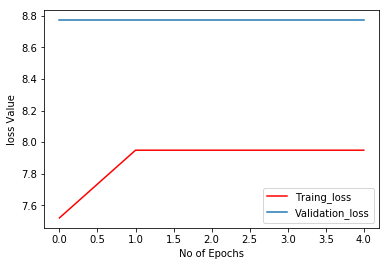

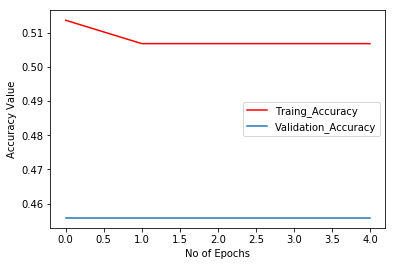

In [11]:
from matplotlib import pyplot as plt

## plot training and validation loss

plt.plot(fitted_model.history['loss'],'r',label='Traing_loss')
plt.plot(fitted_model.history['val_loss'],label='Validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('loss Value')
plt.legend()
plt.show()

## plot Training and validation accuracy

plt.plot(fitted_model.history['accuracy'],'r',label='Traing_Accuracy')
plt.plot(fitted_model.history['val_accuracy'],label='Validation_Accuracy')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()


## Save the model

In [12]:
model.save('face_mask_detection_alert_system.h5')

## Tuning with Keras Tuner

In [13]:
!pip install -q -U keras-tuner
import kerastuner as kt

import tensorflow as tf
from tensorflow import keras

import IPython